In [3]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds
import numpy as np
# Set a random seed
np.random.seed(42)

In [6]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

(2000, 4)


In [7]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [8]:
from qiskit_machine_learning.neural_networks import OpflowQNN

# construct parametrized circuit
inputs = ParameterVector('input', length=4) # 1 extra for label
weights = ParameterVector('weight', length=9)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.u(inputs[0],inputs[1],inputs[2], 0)
qc1.u(weights[0],weights[1],weights[2], 0)
qc1.u(inputs[0],inputs[1],inputs[2], 0)
qc1.u(weights[3],weights[4],weights[5], 0)
qc1.u(inputs[0],inputs[1],inputs[2], 0)
qc1.u(weights[6],weights[7],weights[8], 0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌───────────────────────────────┐┌──────────────────────────────────┐»
  q_0: ┤ U(input[0],input[1],input[2]) ├┤ U(weight[0],weight[1],weight[2]) ├»
       └───────────────────────────────┘└──────────────────────────────────┘»
  «     ┌───────────────────────────────┐┌──────────────────────────────────┐»
  «q_0: ┤ U(input[0],input[1],input[2]) ├┤ U(weight[3],weight[4],weight[5]) ├»
  «     └───────────────────────────────┘└──────────────────────────────────┘»
  «     ┌───────────────────────────────┐┌──────────────────────────────────┐
  «q_0: ┤ U(input[0],input[1],input[2]) ├┤ U(weight[6],weight[7],weight[8]) ├
  «     └───────────────────────────────┘└──────────────────────────────────┘
  )
])


In [11]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv)

In [13]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [11]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize(
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

In [ ]:
plt.plot(losses)

In [16]:
ws = [-0.91709316,  1.57980935, -1.61740473,  1.1182353,  -1.56539397,  1.52962569,
 -1.52987669,  0.00201624,  1.47818211]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.965
tp:  89 tn:  104  fp:  4  fn:  3


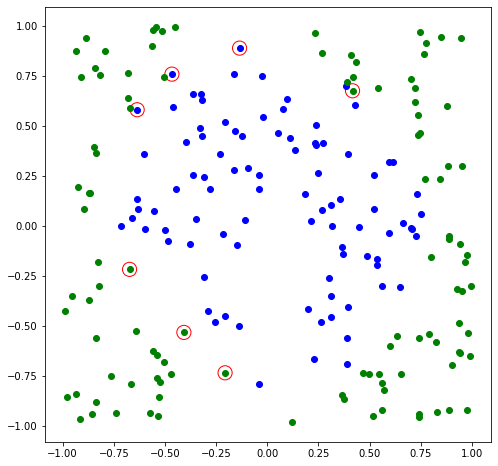

In [17]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [17]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.929
tp:  949 tn:  909  fp:  71  fn:  71


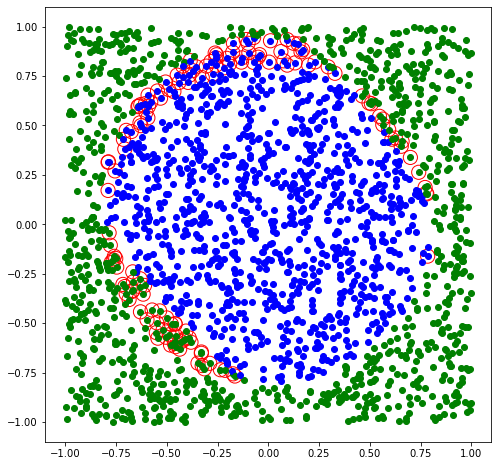

In [18]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()